In [1]:
%matplotlib inline

In [1]:
pip install markupsafe==2.0.1

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pycaret
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
from xgboost import XGBClassifier
# EDA Libraries
import sweetviz as sv
from pandas_profiling import ProfileReport


## Context

There are 4 major output files generated by the IBM AML Sim

- Transactions.csv
    - This is the main csv of the project which contains the transactions simulated by the AML Sim
        - This has a feature which is in high correlation with the target variable is_SAR (Suspicious Activity Report). This must be deleted in order to create a model
        - It contains that the transaction details like originator acc number, beneficiary account number, amount transfered,and timestamp
  
  
- Accounts.csv
    - This had the details of all the accounts which were in the transactions and included details like there account type, loactions details (address, names,dob etc). Few things to take notice in this file is 
        - All the details were complete expect "tx_behavior_id" which had no values. But there were no missing values in the Dataset
        - Many columns had only 1 value through out
        - There are also alot of columns which have categorical data with high cardinality, these are not included in the process of model building to avoid the curse of Dimensionality


- Alert Members.csv
    - This contains data only about is_sar Transactions. These columns are highly correlated to target variable, therefore this table is not used in the modelling procedure.
        - Also this did not have a relevant attribute to merge on with the transactions.csv


- Alert_transactions.csv
    -   This contains more details about SAR transactions and might have relevant patterns about them, but for model building purpose this is highly correlated with the target variable hence ignored. 


# STEP 1 Load data
We start by Loading all the tables to have an overview of the data given

In [98]:
#LOADING TABLE 1 - TRANSACTIONS.CSV
trx = pd.read_csv('amlsim-data/10K/transactions.csv')
trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197905 entries, 0 to 197904
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tran_id         197905 non-null  int64  
 1   orig_acct       197905 non-null  int64  
 2   bene_acct       197905 non-null  int64  
 3   tx_type         197905 non-null  object 
 4   base_amt        197905 non-null  float64
 5   tran_timestamp  197905 non-null  object 
 6   is_sar          197905 non-null  bool   
 7   alert_id        197905 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(2)
memory usage: 10.8+ MB


In [4]:
trx.head()

,tran_id,orig_acct,bene_acct,tx_type,base_amt,tran_timestamp,is_sar,alert_id
0,1,4376,170,TRANSFER,885.30,2017-01-01T00:00:00Z,False,-1
1,2,4300,23,TRANSFER,630.41,2017-01-01T00:00:00Z,False,-1
2,3,4433,12,TRANSFER,393.14,2017-01-01T00:00:00Z,False,-1
3,4,2552,6503,TRANSFER,659.74,2017-01-01T00:00:00Z,False,-1
4,5,2552,6503,TRANSFER,442.44,2017-01-01T00:00:00Z,False,-1


In [5]:
#LOADING TABLE 2 - ACCOUNTS.CSV
acc = pd.read_csv('amlsim-data/10K/accounts.csv')
acc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acct_id           12043 non-null  int64  
 1   dsply_nm          12043 non-null  object 
 2   type              12043 non-null  object 
 3   acct_stat         12043 non-null  object 
 4   acct_rptng_crncy  12043 non-null  object 
 5   prior_sar_count   12043 non-null  bool   
 6   branch_id         12043 non-null  int64  
 7   open_dt           12043 non-null  int64  
 8   close_dt          12043 non-null  int64  
 9   initial_deposit   12043 non-null  float64
 10  tx_behavior_id    0 non-null      float64
 11  bank_id           12043 non-null  object 
 12  first_name        12043 non-null  object 
 13  last_name         12043 non-null  object 
 14  street_addr       12043 non-null  object 
 15  city              12043 non-null  object 
 16  state             12043 non-null  object

In [6]:
acc.head()

,acct_id,dsply_nm,type,acct_stat,acct_rptng_crncy,prior_sar_count,branch_id,open_dt,close_dt,initial_deposit,tx_behavior_id,bank_id,first_name,last_name,street_addr,city,state,country,zip,gender,birth_date,ssn,lon,lat
0,0,C_0,I,A,USD,False,1,0,1000000,83514.28,NaN,bank,Emily,Blair,48764 Howard Forge Apt. 421,Vanessaside,PA,US,19763,Female,2021-12-21,701-43-7736,120.547683,-62.968225
1,1,C_1,I,A,USD,True,1,0,1000000,79773.83,NaN,bank,Dana,Nguyen,387 Grimes Green Apt. 801,Pagetown,NM,US,44165,Female,1914-10-17,196-73-3633,-51.894050,-51.749453
2,2,C_2,I,A,USD,False,1,0,1000000,68338.65,NaN,bank,Anna,Yates,15871 Arnold Squares Apt. 858,Port Carrie,LA,US,58826,Female,1949-05-16,590-31-4757,-81.286230,-39.160654
3,3,C_3,I,A,USD,False,1,0,1000000,70199.02,NaN,bank,Melinda,Massey,471 Erika Curve,North Megan,UT,US,71358,Female,1977-08-13,283-67-3859,-64.464688,68.323549
4,4,C_4,I,A,USD,True,1,0,1000000,90042.39,NaN,bank,Daniel,Norton,477 Miller Ridge Apt. 795,East Allen,DE,US,92950,Male,1951-06-25,437-08-1649,-101.424385,-31.273420


#Other CSV files

In [87]:
#LOADING TABLE 3 - ALERT_ACCOUNTS.CSV
alert_acc = pd.read_csv("amlsim-data/10K/alert_accounts.csv")
alert_acc.head()

,alert_id,alert_type,acct_id,acct_name,is_sar,model_id,start,end,schedule_id,bank_id
0,0,fan_in,376,376,True,2,0,1000000,2,bank
1,0,fan_in,4650,4650,True,2,0,1000000,2,bank
2,0,fan_in,10638,10638,True,2,0,1000000,2,bank
3,0,fan_in,2513,2513,True,2,0,1000000,2,bank
4,0,fan_in,9014,9014,True,2,0,1000000,2,bank


In [88]:
alert_acc.shape

(742, 10)

In [93]:
for i in alert_acc.columns:
    print(alert_acc[i].value_counts())

26    10
74    10
83    10
21    10
19    10
      ..
34     5
70     5
43     5
75     5
64     5
Name: alert_id, Length: 100, dtype: int64
cycle      298
fan_in     230
fan_out    214
Name: alert_type, dtype: int64
5240    1
2828    1
2703    1
682     1
2705    1
       ..
281     1
3410    1
9555    1
9557    1
9285    1
Name: acct_id, Length: 742, dtype: int64
5240    1
2828    1
2703    1
682     1
2705    1
       ..
281     1
3410    1
9555    1
9557    1
9285    1
Name: acct_name, Length: 742, dtype: int64
True    742
Name: is_sar, dtype: int64
3    298
2    230
1    214
Name: model_id, dtype: int64
0    742
Name: start, dtype: int64
1000000    742
Name: end, dtype: int64
2    742
Name: schedule_id, dtype: int64
bank    742
Name: bank_id, dtype: int64


In [95]:
#LOADING TABLE 4 - ALERT_TRANSACTIONS.CSV
alert_trx = pd.read_csv("amlsim-data/10K/alert_transactions.csv")
alert_trx.head(10)

,alert_id,alert_type,is_sar,tran_id,orig_acct,bene_acct,tx_type,base_amt,tran_timestamp
0,28,fan_in,True,39,6568,362,TRANSFER,370.25,2017-01-01T00:00:00Z
1,25,fan_in,True,77,6035,726,TRANSFER,969.03,2017-01-01T00:00:00Z
2,12,fan_in,True,80,1002,546,TRANSFER,359.95,2017-01-01T00:00:00Z
3,23,fan_in,True,85,7518,686,TRANSFER,842.13,2017-01-01T00:00:00Z
4,29,fan_in,True,103,6666,448,TRANSFER,943.53,2017-01-01T00:00:00Z


In [96]:
alert_trx.shape

(671, 9)

In [97]:
for i in alert_acc.columns:
    print(alert_acc[i].value_counts())

26    10
74    10
83    10
21    10
19    10
      ..
34     5
70     5
43     5
75     5
64     5
Name: alert_id, Length: 100, dtype: int64
cycle      298
fan_in     230
fan_out    214
Name: alert_type, dtype: int64
5240    1
2828    1
2703    1
682     1
2705    1
       ..
281     1
3410    1
9555    1
9557    1
9285    1
Name: acct_id, Length: 742, dtype: int64
5240    1
2828    1
2703    1
682     1
2705    1
       ..
281     1
3410    1
9555    1
9557    1
9285    1
Name: acct_name, Length: 742, dtype: int64
True    742
Name: is_sar, dtype: int64
3    298
2    230
1    214
Name: model_id, dtype: int64
0    742
Name: start, dtype: int64
1000000    742
Name: end, dtype: int64
2    742
Name: schedule_id, dtype: int64
bank    742
Name: bank_id, dtype: int64


# STEP 2 - Analysis and Preprocessing

In [60]:
#To get more details about the Account holder of the transaction, lets merge Trx with accounts
df = trx.merge(
    acc,
    how='left',
    left_on='orig_acct',
    right_on='acct_id'
)

df = df.merge(
    acc,
    how='left',
    left_on='bene_acct',
    right_on='acct_id',
    suffixes=('_orig', '_bene')
)


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197905 entries, 0 to 197904
Data columns (total 56 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   tran_id                197905 non-null  int64  
 1   orig_acct              197905 non-null  int64  
 2   bene_acct              197905 non-null  int64  
 3   tx_type                197905 non-null  object 
 4   base_amt               197905 non-null  float64
 5   tran_timestamp         197905 non-null  object 
 6   is_sar                 197905 non-null  bool   
 7   alert_id               197905 non-null  int64  
 8   acct_id_orig           197905 non-null  int64  
 9   dsply_nm_orig          197905 non-null  object 
 10  type_orig              197905 non-null  object 
 11  acct_stat_orig         197905 non-null  object 
 12  acct_rptng_crncy_orig  197905 non-null  object 
 13  prior_sar_count_orig   197905 non-null  bool   
 14  branch_id_orig         197905 non-nu

In [9]:
df.head()

,tran_id,orig_acct,bene_acct,tx_type,base_amt,tran_timestamp,is_sar,alert_id,acct_id_orig,dsply_nm_orig,type_orig,acct_stat_orig,acct_rptng_crncy_orig,prior_sar_count_orig,branch_id_orig,open_dt_orig,close_dt_orig,initial_deposit_orig,tx_behavior_id_orig,bank_id_orig,first_name_orig,last_name_orig,street_addr_orig,city_orig,state_orig,country_orig,zip_orig,gender_orig,birth_date_orig,ssn_orig,lon_orig,lat_orig,acct_id_bene,dsply_nm_bene,type_bene,acct_stat_bene,acct_rptng_crncy_bene,prior_sar_count_bene,branch_id_bene,open_dt_bene,close_dt_bene,initial_deposit_bene,tx_behavior_id_bene,bank_id_bene,first_name_bene,last_name_bene,street_addr_bene,city_bene,state_bene,country_bene,zip_bene,gender_bene,birth_date_bene,ssn_bene,lon_bene,lat_bene
0,1,4376,170,TRANSFER,885.30,2017-01-01T00:00:00Z,False,-1,4376,C_4376,I,A,USD,False,1,0,1000000,63446.28,NaN,bank,Kristin,Gentry,9548 Hooper Manors,Sarahmouth,IA,US,98692,Female,1915-09-20,054-77-5471,90.066499,34.092692,170,C_170,I,A,USD,False,1,0,1000000,84168.61,NaN,bank,Rachel,Doyle,27020 Ashley Springs Apt. 150,Port Jeremy,ME,US,74661,Female,1979-03-23,322-84-8146,151.101223,45.779955
1,2,4300,23,TRANSFER,630.41,2017-01-01T00:00:00Z,False,-1,4300,C_4300,I,A,USD,False,1,0,1000000,79684.15,NaN,bank,Anthony,Taylor,337 Robinson Oval,West Kevintown,NM,US,86415,Male,1964-07-31,081-98-1984,-22.181147,8.679320,23,C_23,I,A,USD,False,1,0,1000000,89199.14,NaN,bank,Angel,Fisher,35833 Kelly Manor,Port Davidtown,CA,US,92535,Female,1981-03-08,427-95-2332,137.331791,23.330428
2,3,4433,12,TRANSFER,393.14,2017-01-01T00:00:00Z,False,-1,4433,C_4433,I,A,USD,False,1,0,1000000,64630.28,NaN,bank,Diana,Gray,82286 Cheryl Station,Nathanport,MS,US,87062,Female,1908-03-01,791-54-9738,-91.241754,-9.061343,12,C_12,I,A,USD,False,1,0,1000000,52909.53,NaN,bank,Brett,Kerr,29456 Kelly Neck Apt. 042,West Richardmouth,MT,US,14742,Male,1970-09-25,346-44-2037,77.207619,-58.859323
3,4,2552,6503,TRANSFER,659.74,2017-01-01T00:00:00Z,False,-1,2552,C_2552,I,A,USD,False,1,0,1000000,79188.34,NaN,bank,Debbie,Jones,35710 Gary Summit,Davidbury,RI,US,54433,Female,1987-05-28,850-93-3097,-16.454245,-39.859187,6503,C_6503,I,A,USD,False,1,0,1000000,57537.45,NaN,bank,Megan,Perry,0952 Kevin Village Apt. 324,South Oscarhaven,MO,US,85424,Female,1994-11-08,010-77-8442,-128.496888,-44.919702
4,5,2552,6503,TRANSFER,442.44,2017-01-01T00:00:00Z,False,-1,2552,C_2552,I,A,USD,False,1,0,1000000,79188.34,NaN,bank,Debbie,Jones,35710 Gary Summit,Davidbury,RI,US,54433,Female,1987-05-28,850-93-3097,-16.454245,-39.859187,6503,C_6503,I,A,USD,False,1,0,1000000,57537.45,NaN,bank,Megan,Perry,0952 Kevin Village Apt. 324,South Oscarhaven,MO,US,85424,Female,1994-11-08,010-77-8442,-128.496888,-44.919702


Doing superficial EDA using predefined libraries to get an idea about the Dataset before moving to model building

- Method 1
__SweetViz__

- Method 2 
__Pandas Profiling__


In [11]:
#EDA using Autoviz
sweet_report = sv.analyze(df)

                                             |          | [  0%]   00:00 -> (? left)

In [12]:
sweet_report.show_html('sweet_report.html')

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/pjain/opt/anaconda3/lib/python3.8/site-packages/missingno/missingno.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(
/Users/pjain/opt/anaconda3/lib/python3.8/site-packages/pandas_profiling/model/missing.py:89: UserWarning: There was an attempt to generate the Count missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Count": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (56).')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

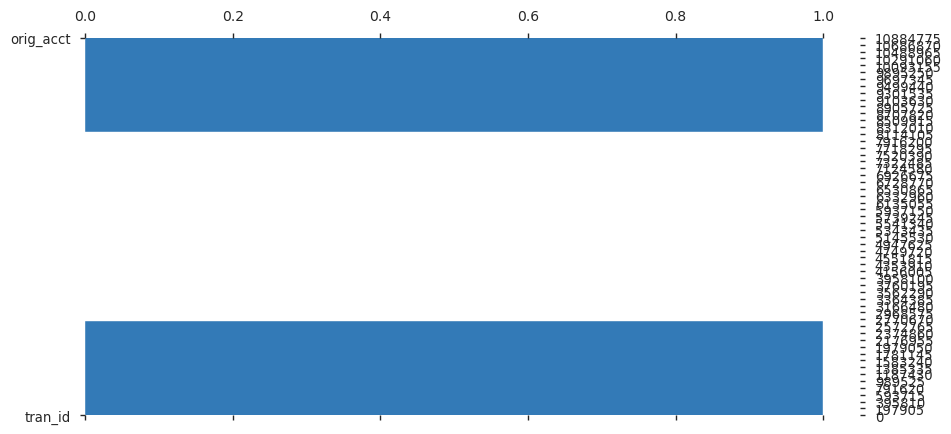

In [13]:

#EDA using pandas-profiling
profile = ProfileReport(df, explorative=True)

#Saving results to a HTML file
profile.to_file("output.html")

In [63]:
#DROPPING Features with only 1 value
df=df.drop(df.nunique()[df.nunique()==1].index, axis=1)

In [64]:
#Dropping highly correlated values. 
df.drop(columns=["lon_bene","lat_bene","lon_orig","lat_orig","ssn_bene","ssn_orig","street_addr_orig","street_addr_bene","dsply_nm_orig","dsply_nm_bene","tx_behavior_id_orig","first_name_orig","last_name_orig","city_orig","state_orig","zip_orig","first_name_bene","last_name_bene","city_bene","state_bene","zip_bene","tx_behavior_id_bene","acct_id_orig","acct_id_bene","alert_id"],inplace=True)

In [65]:
df.head()

,tran_id,orig_acct,bene_acct,base_amt,tran_timestamp,is_sar,prior_sar_count_orig,initial_deposit_orig,gender_orig,birth_date_orig,prior_sar_count_bene,initial_deposit_bene,gender_bene,birth_date_bene
0,1,4376,170,885.30,2017-01-01T00:00:00Z,False,False,63446.28,Female,1915-09-20,False,84168.61,Female,1979-03-23
1,2,4300,23,630.41,2017-01-01T00:00:00Z,False,False,79684.15,Male,1964-07-31,False,89199.14,Female,1981-03-08
2,3,4433,12,393.14,2017-01-01T00:00:00Z,False,False,64630.28,Female,1908-03-01,False,52909.53,Male,1970-09-25
3,4,2552,6503,659.74,2017-01-01T00:00:00Z,False,False,79188.34,Female,1987-05-28,False,57537.45,Female,1994-11-08
4,5,2552,6503,442.44,2017-01-01T00:00:00Z,False,False,79188.34,Female,1987-05-28,False,57537.45,Female,1994-11-08


In [66]:
#Creating a new column age from birthdate
from datetime import datetime, date
# This function converts given date to age
def age(born):
    born = datetime.strptime(born, "%Y-%m-%d").date()
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))
df['age_orig'] = df['birth_date_orig'].apply(age)
df['age_bene'] = df['birth_date_bene'].apply(age)
df.drop(columns=["birth_date_orig","birth_date_bene"],inplace=True)

In [67]:
df.head()

,tran_id,orig_acct,bene_acct,base_amt,tran_timestamp,is_sar,prior_sar_count_orig,initial_deposit_orig,gender_orig,prior_sar_count_bene,initial_deposit_bene,gender_bene,age_orig,age_bene
0,1,4376,170,885.30,2017-01-01T00:00:00Z,False,False,63446.28,Female,False,84168.61,Female,106,43
1,2,4300,23,630.41,2017-01-01T00:00:00Z,False,False,79684.15,Male,False,89199.14,Female,58,41
2,3,4433,12,393.14,2017-01-01T00:00:00Z,False,False,64630.28,Female,False,52909.53,Male,114,51
3,4,2552,6503,659.74,2017-01-01T00:00:00Z,False,False,79188.34,Female,False,57537.45,Female,35,27
4,5,2552,6503,442.44,2017-01-01T00:00:00Z,False,False,79188.34,Female,False,57537.45,Female,35,27


In [69]:
#Checking null values in the dataset
df.isnull().sum()/len(df)*100

tran_id                 0.0
orig_acct               0.0
bene_acct               0.0
base_amt                0.0
tran_timestamp          0.0
is_sar                  0.0
prior_sar_count_orig    0.0
initial_deposit_orig    0.0
gender_orig             0.0
prior_sar_count_bene    0.0
initial_deposit_bene    0.0
gender_bene             0.0
age_orig                0.0
age_bene                0.0
dtype: float64

In [71]:
df["is_sar"].value_counts()

False    197234
True        671
Name: is_sar, dtype: int64

## Analysis Results from EDA Reports

- The Dataset is Imbalanced, only 671 suspicious transactions in approx 20k transactions.
- There are 2090 unique originators which have unique 2090 unique ssn address and like wise for beneficiaries there exist around 4077 unique beneficiary with unique details. (this shows some consistency in dataset)
- Alot of attributes just have 1 value like 
    -All the receiveng curreny is USD
    -All the accounts are based in USA
    -All the accounts have name as C_"account number"
    -and many others, Such data just add noise to the dataset and is therefore should be deleted.
- There are no missing values in the dataset except "tx_behavior_id_bene", All the values for "tx_behavior_id_bene" are missing
- A Few coloumns have very large number of categorical values, therefore its not suitable for Categorical Encoding for model production like zipcode, street addresses, city and states, also latitude and longitude details. Its best to skip these from model creation
- Removing highly correlated variables like "alert_id", 
- Distribution of age is unrealistic as it's range is from '0 years - 116 years of age'

In [101]:
#Setting tran_id as index
df.set_index("tran_id",inplace=True)

In [73]:
#creating pandas profiling report again to see the result of changes done


#EDA using pandas-profiling
profile = ProfileReport(df, explorative=True)

#Saving results to a HTML file
profile.to_file("eda.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# STEP 3 Setup data and feature prep
PyCaret has a setup() function that prompts us with data setup out of the box. We run it here to create training/test data in the right format

In [74]:
from pycaret.classification import *

In [75]:
test = setup(data=df, target='is_sar')

,Description,Value
0,session_id,8129
1,Target,is_sar
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(197905, 13)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


<AxesSubplot:xlabel='base_amt', ylabel='Density'>

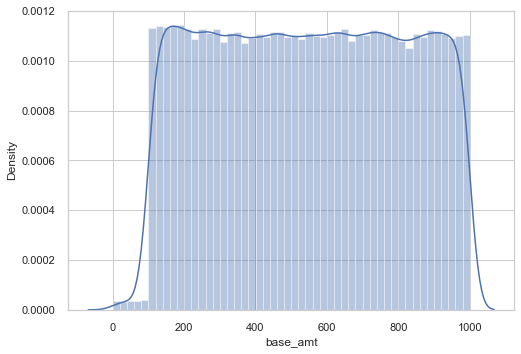

In [79]:
sns.distplot(df.base_amt)

<AxesSubplot:xlabel='initial_deposit_orig', ylabel='Density'>

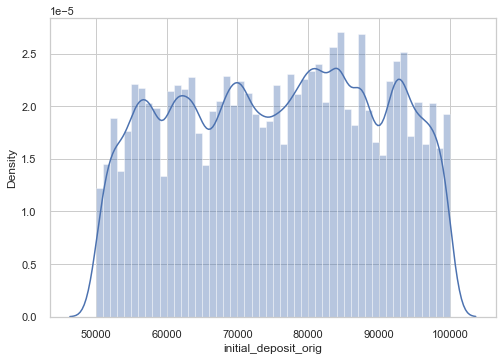

In [80]:
sns.distplot(df.initial_deposit_orig)

<AxesSubplot:xlabel='initial_deposit_bene', ylabel='Density'>

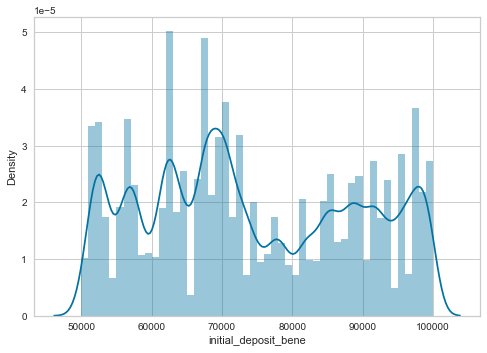

In [42]:
sns.distplot(df.initial_deposit_bene)

<AxesSubplot:xlabel='prior_sar_count_orig', ylabel='count'>

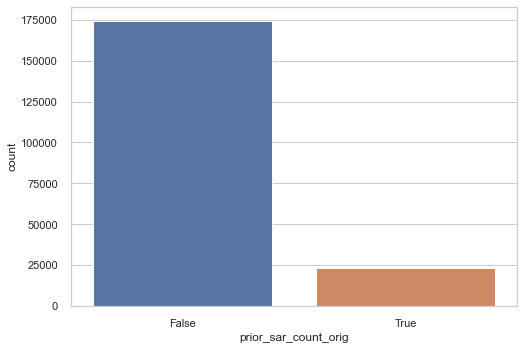

In [58]:
sns.set(style="whitegrid")
sns.countplot(x=df[df['is_sar'] == False].prior_sar_count_orig)


# Train various models and compare performance
The `compare_models()` function lets us train and compare various models. Here we select the best 5

<AxesSubplot:xlabel='prior_sar_count_orig', ylabel='count'>

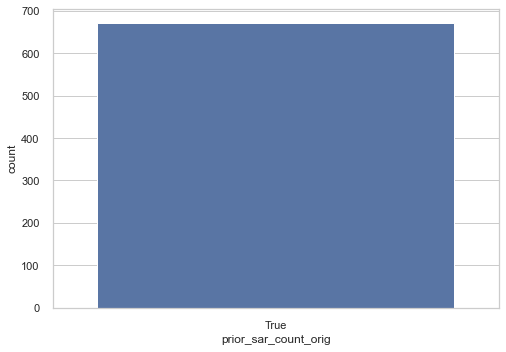

In [136]:

sns.set(style="whitegrid")
sns.countplot(x=df[df['is_sar'] == True].prior_sar_count_orig)

In [117]:
top5 = compare_models(n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9993,0.9993,0.8327,0.9360,0.8807,0.8803,0.8821,4.7410
dt,Decision Tree Classifier,0.9992,0.9216,0.8435,0.8990,0.8696,0.8692,0.8700,0.1010
gbc,Gradient Boosting Classifier,0.9990,0.9972,0.7818,0.9152,0.8411,0.8407,0.8443,6.9150
rf,Random Forest Classifier,0.9989,0.9997,0.7001,0.9649,0.8074,0.8069,0.8193,1.3290
ada,Ada Boost Classifier,0.9988,0.9995,0.7730,0.8603,0.8108,0.8103,0.8132,1.5890
et,Extra Trees Classifier,0.9988,0.9997,0.6607,0.9656,0.7828,0.7823,0.7973,0.9150
knn,K Neighbors Classifier,0.9972,0.6802,0.1542,0.9498,0.2629,0.2622,0.3785,0.5180
lr,Logistic Regression,0.9970,0.8224,0.0974,0.6867,0.1431,0.1428,0.2221,0.8390
ridge,Ridge Classifier,0.9967,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0610
dummy,Dummy Classifier,0.9967,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0390


In [118]:
evaluate_model(top5[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [119]:
evaluate_model(top5[1])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [120]:
print(top5)

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=8129, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0), DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,


# Evaluate model scores
Evaluate the model using graphs to interpret the results

## Evaluating the best Model -1 - XGBOOST

In [121]:
evaluate_model(top5[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [122]:
evaluate_model(top5[1])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [127]:
evaluate_model(top5[0])


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [123]:
evaluate_model(top5[1])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [126]:
evaluate_model(top5[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [124]:
evaluate_model(top5[1])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [125]:

predict_model(top5[0]);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9991,0.9990,0.7972,0.9454,0.8650,0.8645,0.8677


In [130]:
predict_model(top5[1]);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.9990,0.9031,0.8065,0.8974,0.8495,0.8490,0.8502


In [131]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9990,0.9995,0.7609,0.9211,0.8333,0.8328,0.8367
1,0.9992,0.9997,0.8261,0.9268,0.8736,0.8732,0.8746
2,0.9993,0.9966,0.8696,0.9091,0.8889,0.8885,0.8887
3,0.9994,0.9999,0.8667,0.9512,0.9070,0.9067,0.9077
4,0.9994,0.9999,0.8444,0.9500,0.8941,0.8938,0.8954
5,0.9991,0.9996,0.7778,0.9211,0.8434,0.8429,0.8459
6,0.9993,0.9999,0.8000,0.9730,0.8780,0.8777,0.8819
7,0.9995,0.9999,0.9111,0.9318,0.9213,0.9211,0.9212
8,0.9992,0.9985,0.8222,0.9250,0.8706,0.8702,0.8717


In [ ]:
results=pd.DataFrame()
results['columns']=xgboost.get_booster().feature_names
results['importances'] = xgboost.feature_importances_
results.sort_values(by='importances',ascending=False,inplace=True)

results[:40]

In [134]:
dashboard(xgboost, display_format='inline')

Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...
Note: model_output=='probability'. For XGBClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
Building ExplainerDashboard..
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
Generating layout...
Calculating shap values...


100%|===================| 59164/59372 [02:02<00:00]        

Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Generating xgboost model dump...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating predictions...
Calculating pred_percentiles...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard inline (terminate it with ExplainerDashboard.terminate(8050))


## Evaluate model 2 - DT

In [112]:
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9989,0.9236,0.8478,0.8298,0.8387,0.8382,0.8382
1,0.9991,0.9129,0.8261,0.8837,0.8539,0.8535,0.8540
2,0.9994,0.9238,0.8478,0.9512,0.8966,0.8962,0.8977
3,0.9992,0.9442,0.8889,0.8696,0.8791,0.8787,0.8788
4,0.9992,0.9110,0.8222,0.9250,0.8706,0.8702,0.8717
5,0.9992,0.9332,0.8667,0.8864,0.8764,0.8760,0.8761
6,0.9990,0.8887,0.7778,0.8974,0.8333,0.8328,0.8350
7,0.9991,0.9110,0.8222,0.9024,0.8605,0.8600,0.8610
8,0.9990,0.9220,0.8444,0.8444,0.8444,0.8439,0.8439


In [113]:
dashboard(dt, display_format='inline')

Note: model_output=='probability', so assuming that raw shap output of DecisionTreeClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating shap interaction values... (this may take a while)
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating predictions...
Calculating pred_

### Finetuning the XGB model for better recall

In [132]:
tuned_xgb = tune_model(xgboost, optimize = 'Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9973,0.9992,0.9565,0.5570,0.7040,0.7028,0.7288
1,0.9972,0.9993,0.9783,0.5422,0.6977,0.6964,0.7272
2,0.9975,0.9991,0.9348,0.5733,0.7107,0.7095,0.7310
3,0.9972,0.9996,0.9556,0.5375,0.6880,0.6867,0.7156
4,0.9957,0.9997,1.0000,0.4327,0.6040,0.6022,0.6564
5,0.9967,0.9994,0.9556,0.4943,0.6515,0.6500,0.6860
6,0.9974,0.9993,0.9111,0.5616,0.6949,0.6937,0.7143
7,0.9968,0.9995,0.9333,0.5000,0.6512,0.6497,0.6819
8,0.9970,0.9989,0.8667,0.5270,0.6555,0.6541,0.6746


In [135]:
tuned_dt = tune_model(dt, optimize = 'Precision')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9981,0.9984,0.4130,1.0000,0.5846,0.5838,0.6421
1,0.9980,0.9990,0.3913,1.0000,0.5625,0.5617,0.6249
2,0.9984,0.9988,0.5217,1.0000,0.6857,0.6850,0.7217
3,0.9980,0.9989,0.3778,1.0000,0.5484,0.5476,0.6140
4,0.9979,0.9989,0.3556,1.0000,0.5246,0.5238,0.5957
5,0.9979,0.9987,0.3556,1.0000,0.5246,0.5238,0.5957
6,0.9978,0.9979,0.3333,1.0000,0.5000,0.4992,0.5767
7,0.9982,0.9986,0.4444,1.0000,0.6154,0.6146,0.6661
8,0.9979,0.9978,0.3556,1.0000,0.5246,0.5238,0.5957


Finetuning is not an option as the Precision drops way too low 

# Conclusions

The Best Models are 
1. XGBoost
2. Decision Tree

Since the difference between the Precision/Recall is  very small in both the models, The final decision of choosing 
the model is dependent on the business usecase

- If its important for the Client to find all the money laundering transactions at all cost, even at the expense of having high False Positives, then Decision Tree is better model 

- But if the Client needs balance between the False Positives and True Positives at the cost of missing out one or two True posiitives then XGB is more desireable

There are other methods as well which are not in the scope of this project, but can be further explored 
1. Stacking the models together using pycaret
2. Training the model with bigger dataset for better Training